<center>
<img src="MDP.JPG" width=700 height=200 />
</center>

The small MDP shown above provides a simple example of how **maximization bias** can harm the performance of TD control algorithms and how can we avoid this bias using **Double Learning**. The MDP has two non-terminal states A and B. Episodes
always start in A with a choice between two actions, left and right. The right action
transitions immediately to the terminal state with a reward and return of zero. The
left action transitions to B, also with a reward of zero, from which there are many
possible actions all of which cause immediate termination with a reward drawn from a
normal distribution with mean -0.1 and variance 1. Thus, the expected return for
any trajectory starting with left is -0.1, and thus taking left in state A is always a mistake.

In [69]:
import pandas as pd
from collections import defaultdict
import numpy as np
import sys
import matplotlib.pyplot as plt

# Creating the environment :

In [70]:
class Environment():

    def __init__(self):
        self.n_actions = 2
        #0 : left, 1: right
        self.current_state = 'A' #initial state A
    

    def reset(self):
        self.current_state = 'A'
        return 'A'
        

    def step(self, action):
        if action not in range(self.n_actions):
            print('wrong action!')
        if self.current_state == 'A':
            if action == 1:
                return 'F', 0, True
            else:
                self.current_state = 'B'
                return 'B', 0, False
        elif self.current_state == 'B':    
            return 'F', np.random.normal(-0.1, 1), True

# Q-learning

In [71]:
def select_action(Q, state, eps):
    if np.random.rand() > eps:
        if Q[state][0] == Q[state][1]:
            return np.random.choice(np.arange(2))
        else:
            return Q[state].argmax()
    else:
        return np.random.choice(np.arange(2))

In [72]:
#contains the number of left actions taken in state A for each run, episode
left_ratio = np.zeros((10000, 300))
env = Environment()

for run in range(10000):
    Q = defaultdict(lambda: np.zeros(2))
    eps = 0.1
    alpha = 0.1
    gamma = 1
    n_episodes = 300
    avg_return = 0.

    for i in range(n_episodes):
        state = env.reset()
        cur_return = 0.
        
        while True:
            action = select_action(Q, state, eps)
            next_state, reward, done = env.step(action)
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * Q[next_state].max() - Q[state][action])
            if action == 0 and state == 'A':
                left_ratio[run][i] = 1
            state = next_state
            cur_return += reward
            if done:
                break
        
        avg_return += cur_return
        if i % 100 == 0:
            #print(f"Average return on the last 100 episodes : {avg_return / 100}")
            avg_return = 0.

In [73]:
#get average over 10000 runs
left_ratios = left_ratio.sum(axis=0) / 10000

# Double Q-learning

<center>
<img src="double-Q-learning.JPG" width=800 height=400 />
</center>

In [74]:
def select_action(Q1, Q2, state, eps):
    #average state-action value Q1 and Q2 for the current state
    Q_state = Q1[state] + Q2[state]
    if np.random.rand() > eps:
        if Q_state[0] == Q_state[1]:
            return np.random.choice(np.arange(2))
        return Q_state.argmax()
    else:
        return np.random.choice(np.arange(2))

In [75]:
env = Environment()
left_ratio_double = np.zeros((10000, 300))

for run in range(10000):
    Q1 = defaultdict(lambda: np.zeros(2))
    Q2 = defaultdict(lambda: np.zeros(2))
    eps = 0.1
    alpha = 0.1
    gamma = 1
    n_episodes = 300
    avg_return = 0.

    for i in range(n_episodes):
        state = env.reset()
        cur_return = 0.
        
        while True:
            action = select_action(Q1, Q2, state, eps)
            next_state, reward, done = env.step(action)
            rand_value = np.random.randint(0, 2)
            if rand_value == 1:
                max_action = Q1[next_state].argmax()
                Q1[state][action] = Q1[state][action] + alpha * (reward + gamma * Q2[next_state][max_action] - Q1[state][action])
            else:
                max_action = Q2[next_state].argmax()
                Q2[state][action] = Q2[state][action] + alpha * (reward + gamma * Q1[next_state][max_action] - Q2[state][action])
            if action == 0 and state == 'A':
                left_ratio_double[run][i] = 1
            state = next_state
            cur_return += reward
            if done:
                break
        
        avg_return += cur_return
        if i % 100 == 0:
            #print(f"Average return on the last 100 episodes : {avg_return / 100}")
            avg_return = 0.

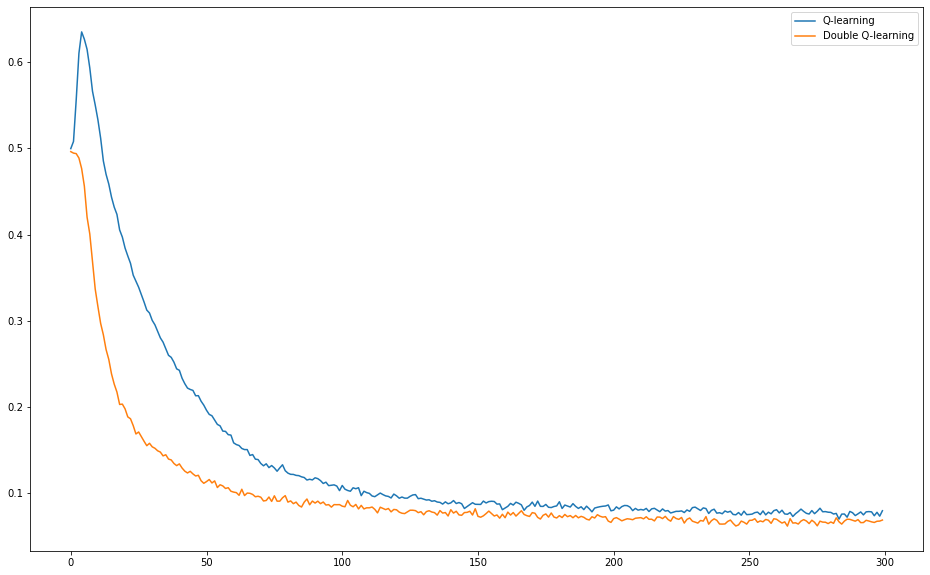

In [76]:
#get average over 10000 runs
left_ratios_double = left_ratio_double.sum(axis=0) / 10000
#plot 
plt.figure(figsize=(16, 10))
qlear_line, = plt.plot(np.arange(left_ratios.shape[0]), left_ratios, label='Q-learning') 
dqlear_line, = plt.plot(np.arange(left_ratios_double.shape[0]), left_ratios_double, label='Double Q-learning')
plt.legend(handles=[qlear_line, dqlear_line])

Comparison of Q-learning and Double Q-learning. 

**Q-learning*** initially learns to take the left action much more often than the right action,
and always takes it significantly more often than the 5% minimum probability enforced by
eps-greedy action selection with eps = 0.1. 

In contrast, **Double Q-learning** is essentially unafected by
maximization bias. 